### Task 3
### Group Data Traffickers - Vansh (23110351), Aditya (23110016), Soham (23110315)

Begin by exploring the [instructor's notebook](#) that introduces the application of Random Fourier Features (RFF) for image reconstruction. Demonstrate the following applications using the cropped image from the notebook:

1. **Super-resolution**: Perform super-resolution on the image shown in the notebook to enhance its resolution by factor 2. Show a qualitative comparison of original and reconstructed image. (i.e display original image and the image you created side by side) **[3 Marks]**

2. The above only helps us with a qualitative comparison. Let us now do a quantitative comparison. Compute the below given metrics: **[1 Marks]**

   - RMSE on predicted v/s ground truth high resolution image
   - Peak SNR on predicted v/s ground truth high resolution image

Follow the below steps to execute this task:

- Start with a 400x400 high-resolution image (the original image).
- Resize it to a 200x200 image (this will be your input image). You can use OpenCV's resize function or another library for this. Here’s a tutorial to help: [OpenCV Resize Image Tutorial](#).
- Use Random Fourier Features (RFF) along with linear regression to learn a function based on the 200x200 image.
- Use the learned function to predict the pixel values for the 400x400 image. This means predicting the values for the pixels that fall between the existing pixels of the 200x200 image.
- Compare your predicted 400x400 image with the original 400x400 high-resolution image.
- Calculate the Root Mean Squared Error (RMSE) and Peak Signal-to-Noise Ratio (PSNR) between the predicted image and the original high-resolution image.


(200, 200, 3)
torch.Size([3, 200, 200])
tensor(0., dtype=torch.float16) tensor(1., dtype=torch.float16)
Epoch 0 loss: 0.314382
Epoch 100 loss: 0.002911
Epoch 200 loss: 0.002832
Epoch 300 loss: 0.002804
Epoch 400 loss: 0.002786
Epoch 500 loss: 0.002774


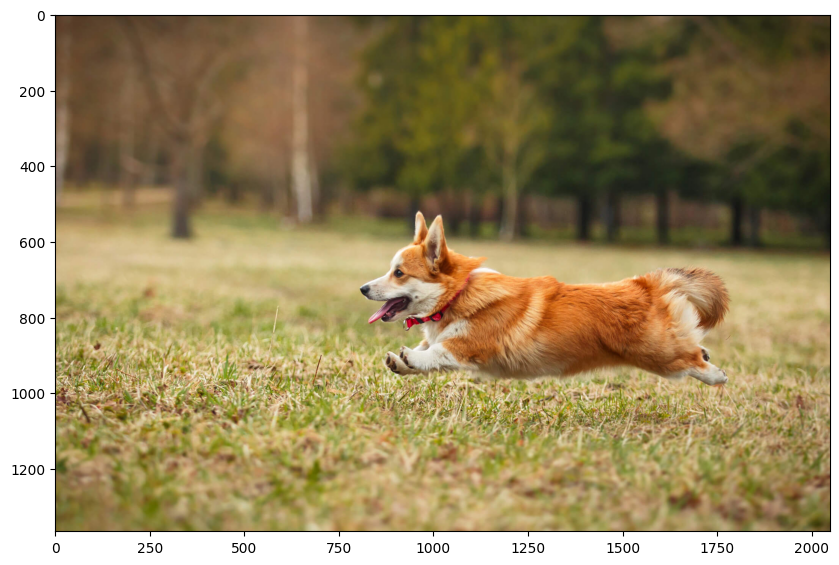

<Figure size 1000x1000 with 0 Axes>

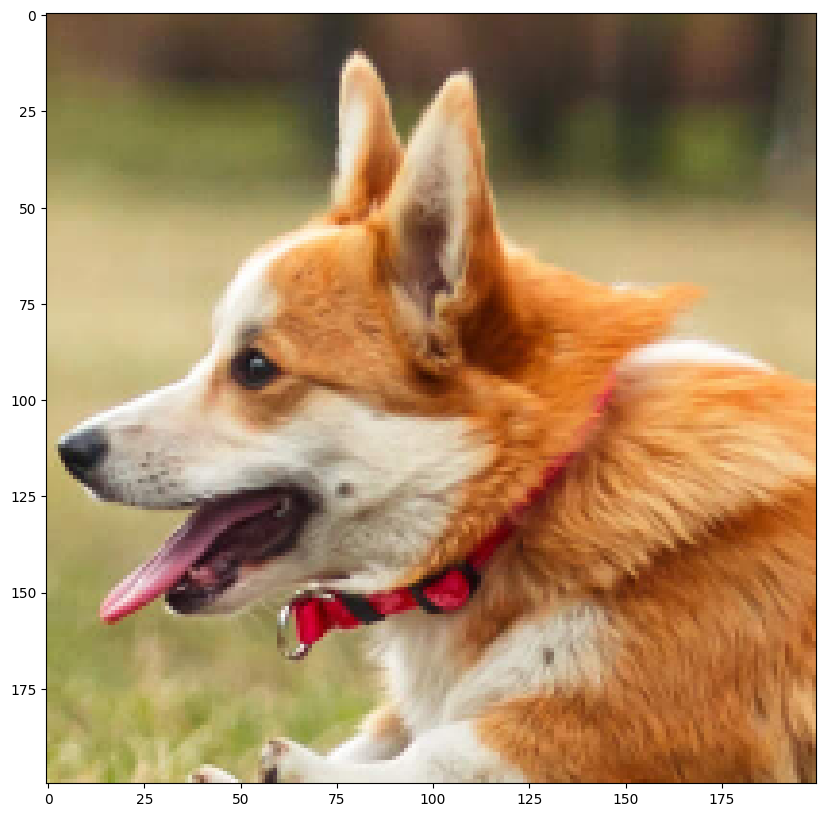

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import cv2

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from einops import rearrange


def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()


def create_coordinate_map(img, scale = 1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    height = int(height * scale)
    width = int(width * scale)

    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float()

    X = X.to(device)

    Y = rearrange(img, 'c h w -> h w c').float()
    return X, Y

class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

net = LinearModel(2, 3)
net.to(device)

def create_rff_features(X, num_features, sigma):
    """
    X: torch.Tensor of shape (num_samples, 2)
    num_features: int
    sigma: float
    """
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state=1)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device), rff


from sklearn import preprocessing

dog = torchvision.io.read_image("./dog.jpg")

plt.figure(figsize=(10, 10))
plt.imshow(rearrange(dog, 'c h w -> h w c').numpy())

scaler = preprocessing.MinMaxScaler().fit(dog.reshape(-1, 1))

scaled_dog = scaler.transform(dog.reshape(-1, 1)).reshape(dog.shape)
scaled_dog = torch.tensor(scaled_dog).float().to(device)


dog_400 = transforms.functional.crop(scaled_dog.cpu(), 500, 800, 400, 400)
plt.figure(figsize=(10, 10))


dog_200 = rearrange(dog_400, 'c h w -> h w c').numpy()
dog_200 = cv2.resize(dog_200, (int(dog_200.shape[1]*0.5), int(dog_200.shape[0]*0.5)), interpolation = cv2.INTER_AREA)
print(dog_200.shape)
plt.figure(figsize=(10, 10))
plt.imshow(dog_200)



dog_200 = torch.tensor(dog_200, dtype=torch.float16).permute(2,0,1).to(device)
print(dog_200.shape)
print(dog_200.min(), dog_200.max())
dog_200

import gc

gc.collect()


X, Y = create_coordinate_map(dog_200)

scaler = preprocessing.MinMaxScaler().fit(X.cpu())
scaled_X = torch.tensor(scaler.transform(X.cpu())).float().to(device)

X_rff, rff = create_rff_features(scaled_X, 10000, 0.03)

net = LinearModel(X_rff.shape[1], 3).to(device)
Y = Y.view(-1, 3)  
Y = Y.to(device)


train(net, 0.02, X_rff, Y, 600)

import gc
del X_rff, X, Y, scaled_X
gc.collect()


X_2, Y_2 = create_coordinate_map(dog_200, scale = 2)


scaler = preprocessing.MinMaxScaler().fit(X_2.cpu())
scaled_X_2 = torch.tensor(scaler.transform(X_2.cpu())).float().to(device)


X_rff = rff.transform(scaled_X_2.cpu().numpy())
X_rff = torch.tensor(X_rff).float().to(device)


In [4]:
def plot_Original_vs_Predicted_Img(OriginalImg, X_rff_pred, net, return_Output = 0):
    """
    OriginalImg: torch.Tensor of shape (num_channels, height, width)
    X_rff_pred: torch.Tensor of shape (num_samples, num_features)
    net: torch.nn.Module
    return_Output: int
    return: torch.Tensor of shape (num_channels, scale*height, scale*width)

    """
    num_channels, height, width = OriginalImg.shape

    with torch.no_grad():
        outputs = net(X_rff_pred)
        pred_img = outputs.to(device)
        print(pred_img.shape)
        pred_img = rearrange(pred_img, '(h w) c -> c h w', h=height, w=width)
    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax0.set_title(f'Original Image ({height}x{width})')
    ax0.imshow(rearrange(OriginalImg, 'c h w -> h w c').cpu().numpy())

    ax1 = plt.subplot(gs[1])
    ax1.set_title(f'Predicted Image ({height}x{width})')
    ax1.imshow(rearrange(pred_img,'c h w -> h w c').cpu().detach().numpy())

    fig.suptitle('Original vs Predicted Image',fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

    if(return_Output == 1):
        return pred_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09253379..1.0259727].


torch.Size([160000, 3])


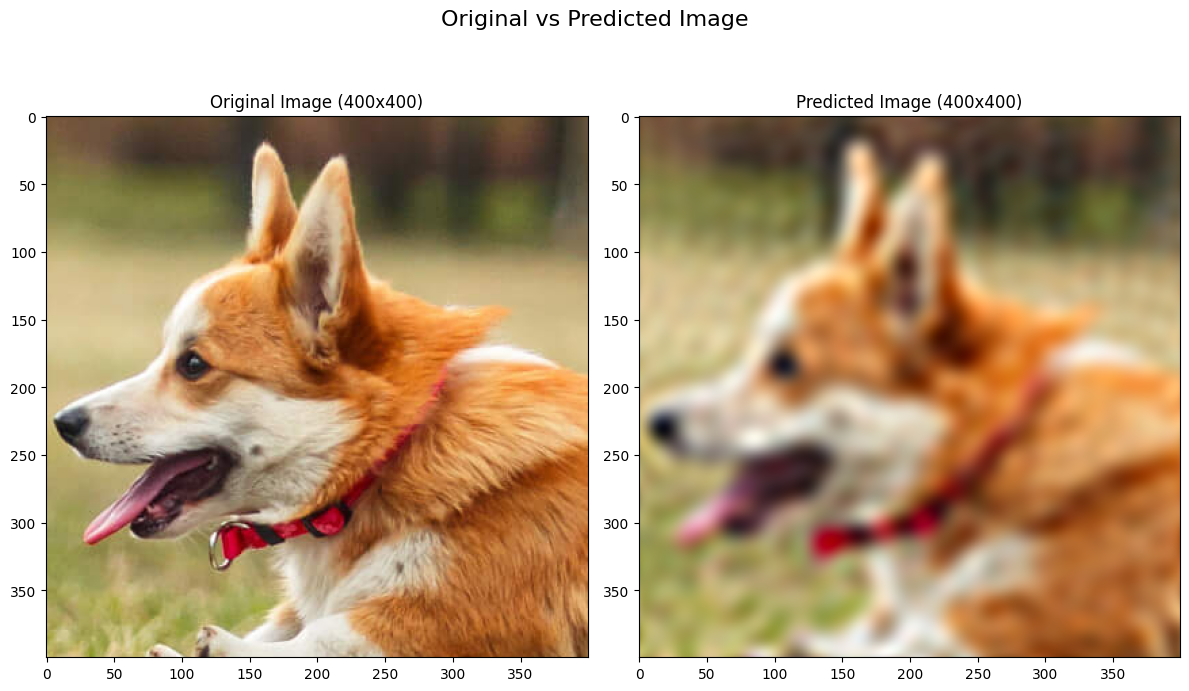

In [5]:
Y = plot_Original_vs_Predicted_Img(dog_400, X_rff, net, return_Output = 1)


In [6]:
Y = Y.to(device)
dog_400 = dog_400.to(device)

mse_loss = nn.MSELoss()
mse = mse_loss(Y, dog_400)

def psnr(original, reconstructed):
    mse = mean_squared_error(original, reconstructed)
    if mse == 0: 
        return 100
    pixel_max = 1.0 
    return 20 * np.log10(pixel_max / np.sqrt(mse))
psnr_value = psnr(dog_400.cpu().flatten().detach().numpy(), Y.cpu().flatten().detach().numpy())

print(f"RMSE: {mse.item()**0.5:.6f}")
print(f"PSNR: {psnr_value:.6f} dB")

RMSE: 0.056124
PSNR: 25.016972 dB
